In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

In [3]:
dataset = pd.read_csv('/content/Harvest_Prediction_Factors_Merged.csv')

# Optionally, assign the dataset to df
df = dataset

# Handle missing values
# df = df.dropna()

df.info()
df.head()

# Check the Dimensions of the Dataset
rows, columns = df.shape
print(f"The dataset contains {rows} rows and {columns} columns.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rainfall (mm)            10000 non-null  float64
 1   Temperature (°C)         10000 non-null  float64
 2   Relative Humidity (%)    10000 non-null  float64
 3   Sunshine Hours (hrs)     10000 non-null  float64
 4   Wind Speed (km/h)        10000 non-null  float64
 5   Soil Type                10000 non-null  object 
 6   Irrigation Type          10000 non-null  object 
 7   Water Source             10000 non-null  object 
 8   Paddy Variety            10000 non-null  object 
 9   Fertilizer Usage (kg)    10000 non-null  float64
 10  Area (hectare)           10000 non-null  float64
 11  Soil Nitrogen (mg/kg)    10000 non-null  int64  
 12  Soil Phosphorus (mg/kg)  10000 non-null  int64  
 13  Soil Potassium (mg/kg)   10000 non-null  int64  
 14  Pest Severity          

In [4]:
# Define Features and Target
X = df.drop(columns=[' Yield (kg)'])
y = df[' Yield (kg)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display training and testing sizes
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (8000, 17)
Testing data size: (2000, 17)


In [5]:
# List of categorical and numerical columns
categorical_features = ['Soil Type', 'Irrigation Type', 'Water Source', 'Paddy Variety', 'Pest Severity', 'Season', 'District']
numerical_features = ['Rainfall (mm)', 'Temperature (°C)', 'Relative Humidity (%)', 'Sunshine Hours (hrs)', 'Wind Speed (km/h)',
                      'Fertilizer Usage (kg)', 'Area (hectare)', 'Soil Nitrogen (mg/kg)', 'Soil Phosphorus (mg/kg)', 'Soil Potassium (mg/kg)']

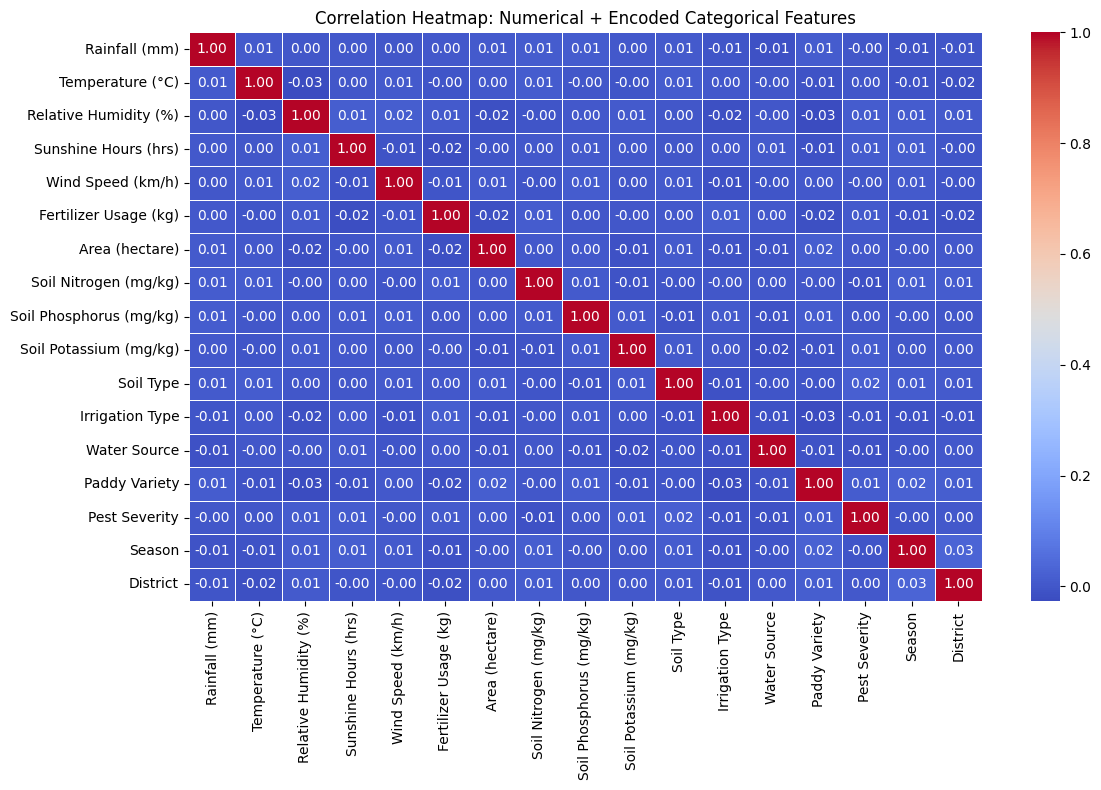

In [6]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Make a copy of the dataframe to encode
df_encoded = df.copy()

# Encode all categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Combine numerical and encoded categorical features
all_features = numerical_features + categorical_features

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded[all_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Numerical + Encoded Categorical Features')
plt.tight_layout()
plt.show()

In [7]:
# Preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing numerical values with mean
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Apply OneHot encoding
])

# Bundle preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\nPreprocessor Details:")
print(preprocessor)


Preprocessor Details:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Rainfall (mm)', 'Temperature (°C)',
                                  'Relative Humidity (%)',
                                  'Sunshine Hours (hrs)', 'Wind Speed (km/h)',
                                  'Fertilizer Usage (kg)', 'Area (hectare)',
                                  'Soil Nitrogen (mg/kg)',
                                  'Soil Phosphorus (mg/kg)',
                                  'Soil Potassium (mg/kg)']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Soil Ty

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import joblib
import numpy as np

# Create the pipeline with Gradient Boosting Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])
# Parameter distribution for Random Search
param_distributions = {
    'model__n_estimators': np.arange(100, 500, 50),
    'model__learning_rate': np.linspace(0.01, 0.2, 10),
    'model__max_depth': [3, 4, 5, 6, 7],
    'model__min_samples_split': [2, 4, 6, 8],
    'model__min_samples_leaf': [1, 2, 4, 6],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__max_features': ['sqrt', 'log2', None]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,              # Number of parameter settings sampled
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
pipeline = random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:")
print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters:
{'model__subsample': 0.6, 'model__n_estimators': np.int64(400), 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': 7, 'model__learning_rate': np.float64(0.03111111111111111)}


In [9]:
# Evaluate model performance on training and test sets
train_accuracy = r2_score(y_train, pipeline.predict(X_train))
test_accuracy = r2_score(y_test, pipeline.predict(X_test))

# Print accuracy results
print(f'Training R² Score: {train_accuracy:.4f}')
print(f'Test R² Score: {test_accuracy:.4f}')

Training R² Score: 0.9993
Test R² Score: 0.9734


In [10]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print MAE, MSE, and R-squared
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

# Print MAPE and Accuracy
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Regression Accuracy: {accuracy:.2f}%")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

MAE: 391.55652708971013
MSE: 4705001.681313624
R-squared: 0.9733682654979736
Mean Absolute Percentage Error (MAPE): 3.31%
Regression Accuracy: 96.69%
RMSE: 2169.1016


In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
file_path = '/content/Harvest_Prediction_Factors_Merged.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Split the data into 80% training and 20% testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the test data to a CSV file
test_file_path = '/content/Harvest_Prediction_Test_Data.csv'  # Update with desired save location
test_data.to_csv(test_file_path, index=False)

print(f"Test data saved to: {test_file_path}")

Test data saved to: /content/Harvest_Prediction_Test_Data.csv


In [14]:
# Save the model
model_path = "rice_yield_GradientBoostRegressor_model.pkl"
joblib.dump(pipeline, model_path)
print(f"Model saved to {model_path}")

Model saved to rice_yield_GradientBoostRegressor_model.pkl


**Test data Performance**

Mean Squared Error (MSE): 4705001.681313624
Mean Absolute Error (MAE): 391.55652708971013


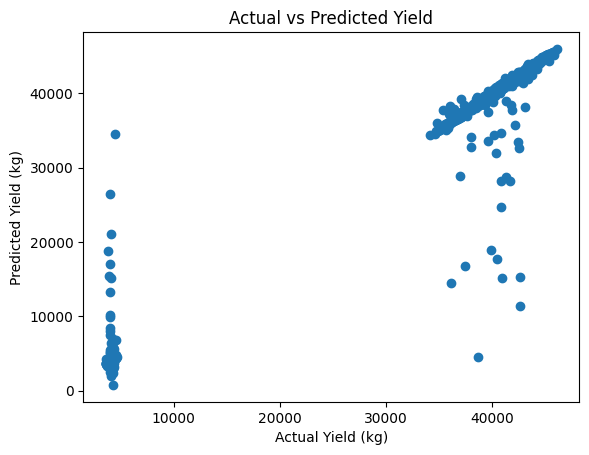

In [17]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the test data
test_file_path = '/content/Harvest_Prediction_Test_Data.csv'  # Update with your test data path
test_data = pd.read_csv(test_file_path)

# Separate features and target variable
X_test = test_data.drop(columns=[' Yield (kg)'])  # Replace 'Yield (kg)' with your target column name
y_test = test_data[' Yield (kg)']  # Replace 'Yield (kg)' with your target column name

# Load your trained model (ensure the model is trained and saved)
import joblib
model = joblib.load('rice_yield_GradientBoostRegressor_model.pkl')  # Update with your model path

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Optionally, visualize the results
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Yield (kg)")
plt.ylabel("Predicted Yield (kg)")
plt.title("Actual vs Predicted Yield")
plt.show()


**Visualize Model Performance**

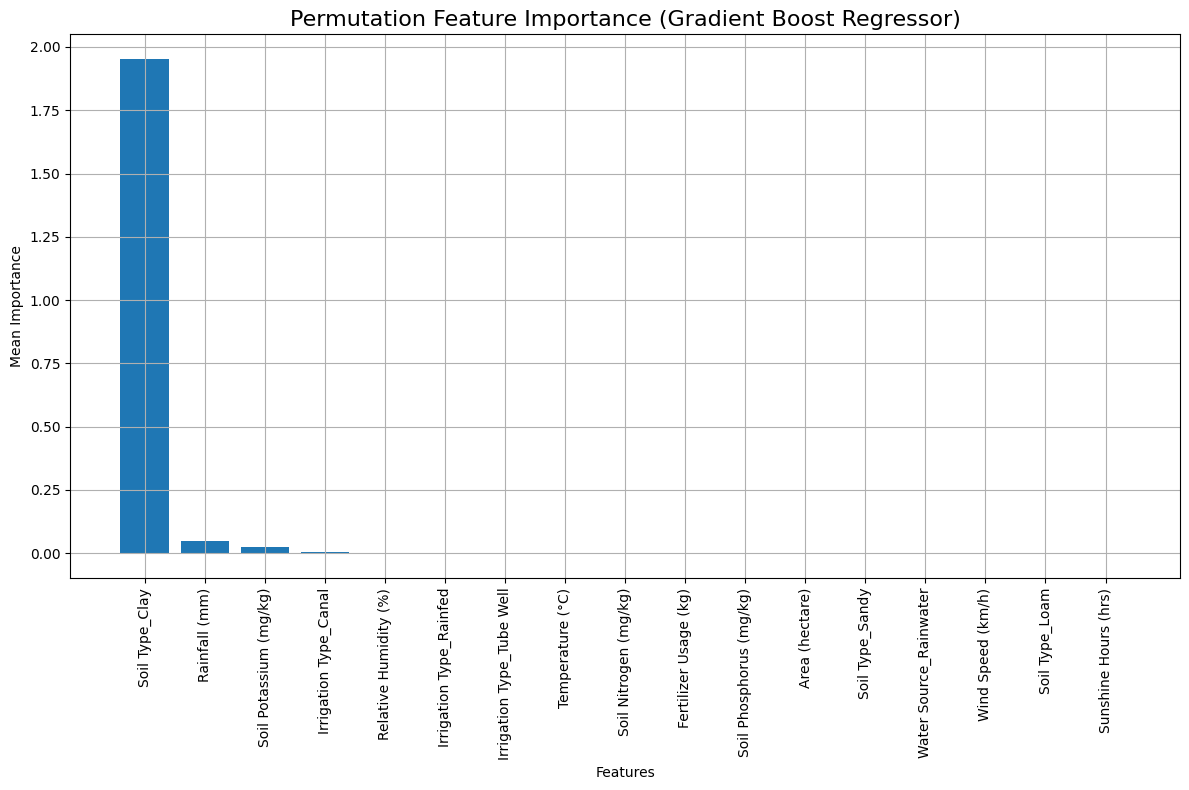

In [21]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')

# Get feature names
categorical_feature_names = pipeline.best_estimator_.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, categorical_feature_names])

# Sort and plot
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), all_feature_names[sorted_idx], rotation=90)
plt.title("Permutation Feature Importance (Gradient Boost Regressor)", fontsize=16)
plt.xlabel("Features")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.grid(True)
plt.show()

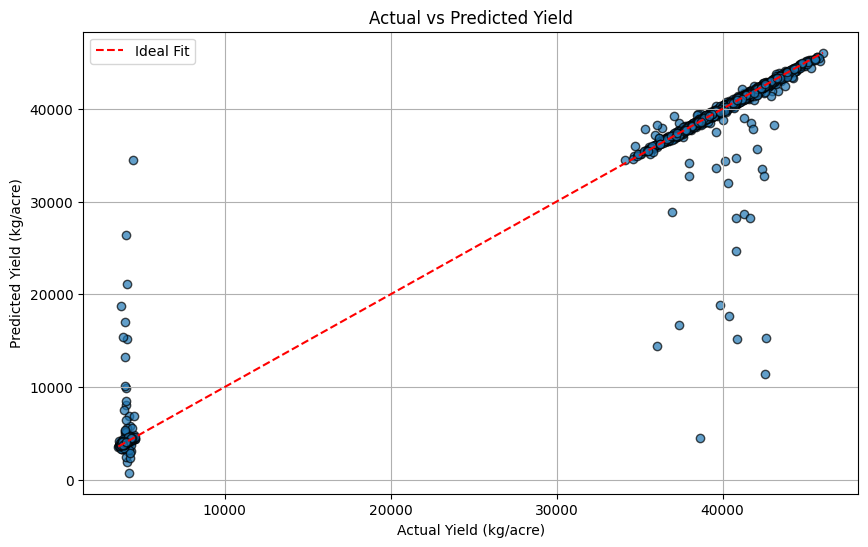

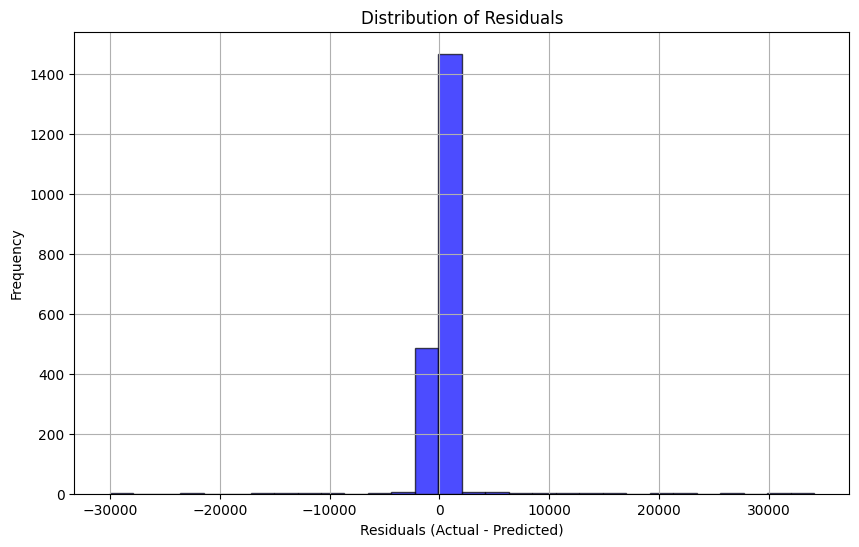

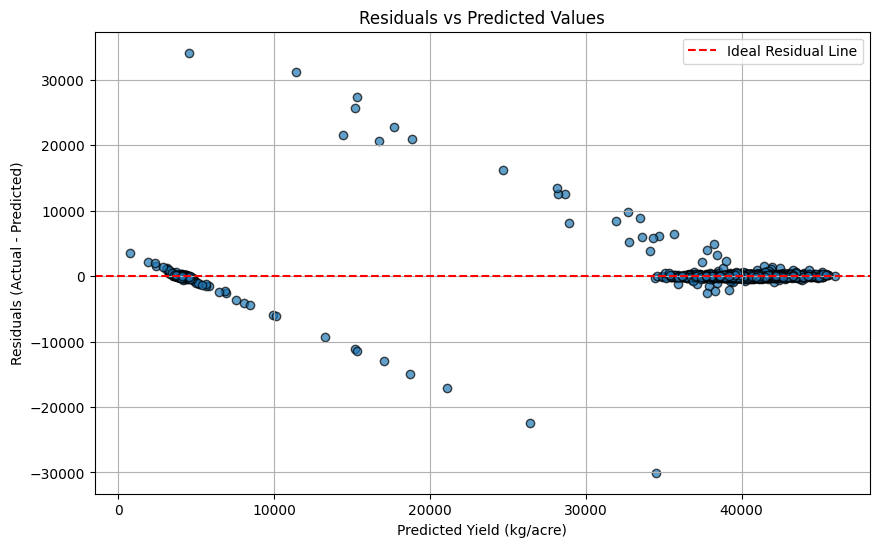

In [19]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")
plt.title("Actual vs Predicted Yield")
plt.xlabel("Actual Yield (kg/acre)")
plt.ylabel("Predicted Yield (kg/acre)")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='k')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', label="Ideal Residual Line")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Yield (kg/acre)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.show()

**Comparison of Predicted and Test data**

In [20]:
import pandas as pd

# Function to predict harvest based on input test data
def predict_test_data(model, test_data):
    # Prepare to store results
    results = []

    # Iterate through test data rows
    for index, row in test_data.iterrows():
        # Extract input features
        new_data = pd.DataFrame([{
            'Rainfall (mm)': row['Rainfall (mm)'],
            'Temperature (°C)': row['Temperature (°C)'],
            'Relative Humidity (%)': row['Relative Humidity (%)'],
            'Sunshine Hours (hrs)': row['Sunshine Hours (hrs)'],
            'Wind Speed (km/h)': row['Wind Speed (km/h)'],
            'Soil Type': row['Soil Type'],
            'Irrigation Type': row['Irrigation Type'],
            'Water Source': row['Water Source'],
            'Paddy Variety': row['Paddy Variety'],
            'Fertilizer Usage (kg)': row['Fertilizer Usage (kg)'],
            'Area (hectare)': row['Area (hectare)'],
            'Soil Nitrogen (mg/kg)': row['Soil Nitrogen (mg/kg)'],
            'Soil Phosphorus (mg/kg)': row['Soil Phosphorus (mg/kg)'],
            'Soil Potassium (mg/kg)': row['Soil Potassium (mg/kg)'],
            'Pest Severity': row['Pest Severity'],
            'Season': row['Season'],
            'District': row['District']
        }])

        # Predict the total yield
        predicted_yield = model.predict(new_data)[0]

        # Store actual and predicted values
        results.append({
            "Actual Yield": row[' Yield (kg)'],
            "Predicted Yield": predicted_yield
        })

    # Return results as a DataFrame
    return pd.DataFrame(results)

# Load the test data
test_file_path = '/content/Harvest_Prediction_Test_Data.csv'
test_data = pd.read_csv(test_file_path)

# Load your trained model
import joblib
pipeline = joblib.load('rice_yield_GradientBoostRegressor_model.pkl')

# Predict for test data and compare
results_df = predict_test_data(pipeline, test_data)

# Save the results for evaluation
results_df.to_csv('/content/Prediction_Results.csv', index=False)

print("Prediction results saved to '/content/Prediction_Results.csv'")


Prediction results saved to '/content/Prediction_Results.csv'


**Farmer input data predict harvest based on land size**

In [ ]:
import pandas as pd

# Function to predict harvest based on input acreage and other factors, including recommendations based on yield comparison
def predict_total_harvest():
    # Step 1: Farmer inputs various factors
    print("=== Enter Farm Data ===")

    district = input("Enter the district: ")
    season = input("Enter the season (e.g., Maha, Yala): ")
    area = float(input("Enter the total area of land in hectares: "))
    rainfall = float(input("Enter the total rainfall in mm: "))
    temperature = float(input("Enter the temperature in °C: "))
    humidity = float(input("Enter the relative humidity percentage: "))
    sunshine_hours = float(input("Enter the total sunshine hours per day: "))
    wind_speed = float(input("Enter the average wind speed in km/h: "))
    soil_type = input("Enter the soil type (e.g., Loam, Sandy, Clay): ")
    irrigation_type = input("Enter the irrigation type (e.g., Rainfed, Canal, Tube Well): ")
    water_source = input("Enter the water source (e.g., Well, River, Rainwater): ")
    paddy_variety = input("Enter the paddy variety (e.g., BG 450, BG 250 , BG 350 , BG 360 ): ")
    fertilizer_usage = float(input("Enter the fertilizer usage in kg: "))
    soil_nitrogen = float(input("Enter the soil nitrogen level in mg/kg: "))
    soil_phosphorus = float(input("Enter the soil phosphorus level in mg/kg: "))
    soil_potassium = float(input("Enter the soil potassium level in mg/kg: "))
    pest_severity = input("Enter the pest severity (e.g., Low, Medium, High): ")


    # Step 2: Input for previous yield per acre
    previous_yield_per_hectare = float(input("Enter the previous yield per hectare in kg: "))

    # Step 3: Prepare the data for prediction
    new_data = pd.DataFrame([{
        'Rainfall (mm)': rainfall,
        'Temperature (°C)': temperature,
        'Relative Humidity (%)': humidity,
        'Sunshine Hours (hrs)': sunshine_hours,
        'Wind Speed (km/h)': wind_speed,
        'Soil Type': soil_type,
        'Irrigation Type': irrigation_type,
        'Water Source': water_source,
        'Paddy Variety': paddy_variety,
        'Fertilizer Usage (kg)': fertilizer_usage,
        'Area (hectare)': area,  # This is still used, but model predicts per acre
        'Soil Nitrogen (mg/kg)': soil_nitrogen,
        'Soil Phosphorus (mg/kg)': soil_phosphorus,
        'Soil Potassium (mg/kg)': soil_potassium,
        'Pest Severity': pest_severity,
        'Season': season,
        'District': district
    }])

    # Step 4: Predict the total yield using the trained model
    Total_predicted_yield = pipeline.predict(new_data)[0]

    # Step 5: Calculate yield per acre (Optional, as yield prediction might already be per acre)
    predicted_yield_per_hectare = Total_predicted_yield / area

    # Step 6: Display the predicted results
    print(f"\n=== Predicted Results ===")
    print(f"Total Harvest for {area} hectare: {Total_predicted_yield:.2f} kg")
    print(f"Predicted Yield per hectare: {predicted_yield_per_hectare:.2f} kg")
    print("=========================")

    # Step 7: Compare the previous yield with the predicted yield and provide recommendations
    print("\n=== Recommendations Based on Yield Comparison ===")

    if previous_yield_per_hectare > predicted_yield_per_hectare:
        print("Condition: Previous Yield > Predicted Yield")
        print("\nPredicted Yield is LOWER than the Previous Yield.")
        print("Suggested Actions to Improve Yield:")
        print("- Optimize fertilizer usage based on soil tests.")
        print("- Improve irrigation practices to ensure consistent water supply.")
        print("- Consider pest control measures to minimize yield loss.")
        print("- Use high-yield paddy varieties suitable for the district.")
        print("- Apply balanced soil nutrients and organic matter.")

    elif predicted_yield_per_hectare > previous_yield_per_hectare:
        print("Condition: Predicted Yield > Previous Yield")
        print("\nPredicted Yield is HIGHER than the Previous Yield.")
        print("Recommendations for Maintaining or Further Improving Yield:")
        print("- Continue current agricultural practices.")
        print("- Monitor soil health regularly and apply nutrients accordingly.")
        print("- Use precision farming tools to track crop progress.")
        print("- Plan for seasonal crop rotation to maintain soil fertility.")
        print("- Use modern harvesting techniques to minimize post-harvest losses.")

    else:
        print("Condition: Previous Yield == Predicted Yield")
        print("\nPredicted Yield matches the Previous Yield. Keep up the current practices!")

    print("===========================")
    return Total_predicted_yield, predicted_yield_per_hectare

# Run the function
predict_total_harvest()